In [3]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics/Jaguas"
    root_path = "media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [3]:
root_audios = f"{root}/Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv"
root_recorders = f"{root}/Complementary_Files/df_grabadoras_reg.csv"

ecological_integrity = f"{root}/Complementary_Files/Indice_Integridad_Ecologica.xlsx"

audios = pd.read_csv(root_audios, index_col=0)
recorders = pd.read_csv(root_recorders, sep=";")
ei  = pd.read_excel(ecological_integrity)

audios.set_index("Filename", inplace=True)

In [13]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_ai[['location', 'day', 'hour']] =df_ai['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_ai['hour_stage'] =df_ai['hour'].apply(define_hour_stage)
df_ai.set_index("y", inplace=True)
df_ai['Habitat'] = df_ai.index.map(audios['Habitat'])

In [5]:
df_ai = pd.read_csv("New_df_ai.csv")
df_ai.set_index("y", inplace=True)

In [6]:
# df_ai.to_csv(f'New_df_ai.csv')

## All classification Covers

Accuracy: 0.8714159030446349
f1: 0.8198458754627023
recall 0.7953274706732656
[[0.95772947 0.04227053]
 [0.36707453 0.63292547]]
[[2379  105]
 [ 330  569]]


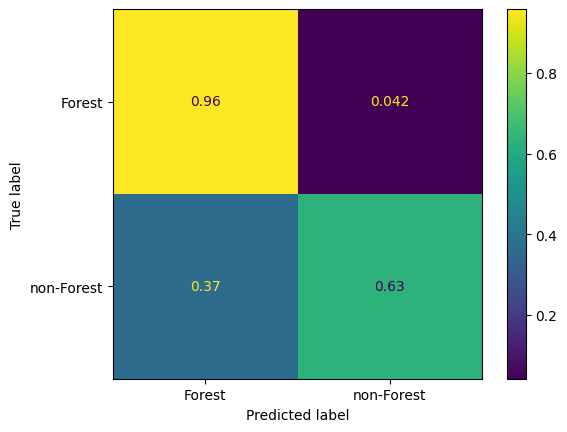

In [27]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = np.asarray(df_ai.iloc[:,0:60])
y = np.asarray(df_ai.loc[:,"Habitat"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="true")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["Forest", "non-Forest"])
cm_display.plot()
plt.show()

## All classification Hours

Accuracy: 0.8714159030446349
f1: 0.8468978957980965
recall 0.8414732146907107
[[0.9091653  0.05646481 0.03436989]
 [0.1503876  0.70232558 0.14728682]
 [0.05474934 0.0323219  0.91292876]]
[[1111   69   42]
 [  97  453   95]
 [  83   49 1384]]


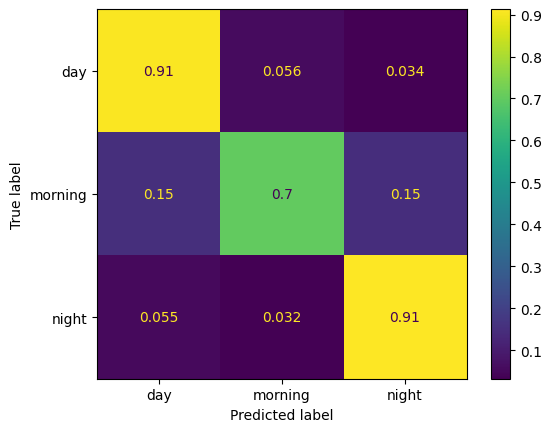

In [28]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_ai.iloc[:,0:60])
y = np.asarray(df_ai.loc[:,"hour_stage"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="true")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["day", "morning", "night"])
cm_display.plot()
plt.show()

## Cover classification

In [10]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_ai_cover = []
f1_scores_ai_cover = []
recalls_ai_cover = []
df_day={}
days = list(range(1,31))
for i in range(len(days)):
    days[i] = str(days[i])
for i in days:
    df_day = df_ai[df_ai['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:60])
    y = np.asarray(df_day.loc[:,"Habitat"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ai_cover.append(accuracy)
    f1_scores_ai_cover.append(f1_score)
    recalls_ai_cover.append(recall)
    
np.save(f"{root}/temporal/classification_results/accuracies_ai_covers.npy", accuracies_ai_cover)
np.save(f"{root}/temporal/classification_results/f1_scores_ai_covers.npy", f1_scores_ai_cover)
np.save(f"{root}/temporal/classification_results/recalls_ai_covers.npy", recalls_ai_cover)

Accuracy: 0.9316239316239316
f1: 0.7813084112149533
recall 0.7142857142857143
Accuracy: 0.8857142857142857
f1: 0.695357833655706
recall 0.6470588235294118
Accuracy: 0.9519230769230769
f1: 0.9052305449243667
recall 0.8948863636363636
Accuracy: 0.9459459459459459
f1: 0.8422174840085288
recall 0.7777777777777778
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 0.9431818181818182
f1: 0.8834437086092716
recall 0.8333333333333333
Accuracy: 0.92
f1: 0.9095431931252826
recall 0.8949652777777778
Accuracy: 0.9042553191489362
f1: 0.9017535710138196
recall 0.9032634032634033
Accuracy: 0.8956521739130435
f1: 0.8885658914728682
recall 0.8804347826086957
Accuracy: 0.9058823529411765
f1: 0.896969696969697
recall 0.8873820754716981
Accuracy: 0.9139784946236559
f1: 0.9110047846889953
recall 0.9050187617260788
Accuracy: 0.918918918918919
f1: 0.9068183938065479
recall 0.8875
Accura

## Hour Stage Classification

In [9]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_ai_hour = []
f1_scores_ai_hour = []
recalls_ai_hour = []
df_day={}
days = list(range(1,31))
for i in range(len(days)):
    days[i] = str(days[i])
for i in days:
    df_day = df_ai[df_ai['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:60])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ai_hour.append(accuracy)
    f1_scores_ai_hour.append(f1_score)
    recalls_ai_hour.append(recall)
    
np.save(f"{root}/temporal/classification_results/accuracies_ai_hours.npy", accuracies_ai_hour)
np.save(f"{root}/temporal/classification_results/f1_scores_ai_hours.npy", f1_scores_ai_hour)
np.save(f"{root}/temporal/classification_results/recalls_ai_hours.npy", recalls_ai_hour)

Accuracy: 0.8290598290598291
f1: 0.7840155945419104
recall 0.7782393589847006
Accuracy: 0.8380952380952381
f1: 0.8115512491688041
recall 0.7836923111066726
Accuracy: 0.875
f1: 0.8475857452799703
recall 0.8333439321674616
Accuracy: 0.9324324324324325
f1: 0.9366891896517494
recall 0.9302737520128824
Accuracy: 0.8769230769230769
f1: 0.8215449121109498
recall 0.7929292929292929
Accuracy: 0.8586956521739131
f1: 0.8379376876083579
recall 0.839095744680851
Accuracy: 0.9540229885057471
f1: 0.9528253781127344
recall 0.956501182033097
Accuracy: 0.8478260869565217
f1: 0.8264012196215585
recall 0.8321133550871623
Accuracy: 0.9130434782608695
f1: 0.9062784997720018
recall 0.9126361655773421
Accuracy: 0.9090909090909091
f1: 0.8846114695066866
recall 0.8608785175017158
Accuracy: 0.89
f1: 0.8664910249757162
recall 0.8821118991331757
Accuracy: 0.9148936170212766
f1: 0.8797779472836682
recall 0.9130952380952381
Accuracy: 0.8347826086956521
f1: 0.8095357172626491
recall 0.8143719806763285
Accuracy: 0.882